In [1]:
import torch
import torch.nn as nn
import numpy as np
import scipy.io
from matplotlib import pyplot as plt
import matplotlib.animation as animation

In [2]:
nu = 0.01

In [16]:
class NavierStokes(nn.Module):
    
    def __init__(self, X, Y, T, u, v):
        super(NavierStokes,self).__init__()
        self.x = X
        self.y = Y
        self.t = T

        self.u = u
        self.v = v

        #null vector to test against f and g:
        self.null = torch.zeros((self.x.shape[0], 1))

        # initialize network:
        self.network()

        self.optimizer = torch.optim.LBFGS(self.net.parameters(), lr=1, max_iter=200000, max_eval=50000,
                                           history_size=50, tolerance_grad=1e-05, tolerance_change=0.5 * np.finfo(float).eps,
                                           line_search_fn="strong_wolfe")

        self.mse = nn.MSELoss()

        #loss
        self.ls = 0

        #iteration number
        self.iter = 0

    def network(self):

        self.net = nn.Sequential(
            nn.Linear(3, 20), nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 2))

    def function(self, x, y, t):

        res = self.net(torch.hstack((x, y, t)))
        psi, p = res[:, 0:1], res[:, 1:2]
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        u = torch.autograd.grad(psi, y, grad_outputs=torch.ones_like(psi), create_graph=True)[0] #retain_graph=True,
        v = -1.*torch.autograd.grad(psi, x, grad_outputs=torch.ones_like(psi), create_graph=True)[0]

        u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
        u_y = torch.autograd.grad(u, y, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        u_yy = torch.autograd.grad(u_y, y, grad_outputs=torch.ones_like(u_y), create_graph=True)[0]
        u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]

        v_x = torch.autograd.grad(v, x, grad_outputs=torch.ones_like(v), create_graph=True)[0]
        v_xx = torch.autograd.grad(v_x, x, grad_outputs=torch.ones_like(v_x), create_graph=True)[0]
        v_y = torch.autograd.grad(v, y, grad_outputs=torch.ones_like(v), create_graph=True)[0]
        v_yy = torch.autograd.grad(v_y, y, grad_outputs=torch.ones_like(v_y), create_graph=True)[0]
        v_t = torch.autograd.grad(v, t, grad_outputs=torch.ones_like(v), create_graph=True)[0]

        p_x = torch.autograd.grad(p, x, grad_outputs=torch.ones_like(p), create_graph=True)[0]
        p_y = torch.autograd.grad(p, y, grad_outputs=torch.ones_like(p), create_graph=True)[0]

        f = u_t + u * u_x + v * u_y + p_x - nu * (u_xx + u_yy)
        g = v_t + u * v_x + v * v_y + p_y - nu * (v_xx + v_yy)

        return u, v, p, f, g

    def closure(self):
        # reset gradients to zero:
        self.optimizer.zero_grad()
        # u, v, p, g and f predictions:
        u_prediction, v_prediction, p_prediction, f_prediction, g_prediction = self.function(self.x, self.y, self.t)
        
        # calculate losses
        u_loss = self.mse(u_prediction, self.u)
        v_loss = self.mse(v_prediction, self.v)
        f_loss = self.mse(f_prediction, self.null)
        g_loss = self.mse(g_prediction, self.null)
        self.ls = u_loss + v_loss + f_loss +g_loss

        # derivative with respect to net's weights:
        self.ls.backward()

        self.iter += 1
        if not self.iter % 1:
            print('Iteration: {:}, Loss: {:0.6f}'.format(self.iter, self.ls))

        return self.ls

    def train(self):

        # training loop
        self.net.train()
        self.optimizer.step(self.closure)

In [4]:
N_train = 5000

In [5]:
data = scipy.io.loadmat('../../Data/cylinder_wake/cylinder_wake.mat')

In [6]:
# Device selection
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')

In [7]:
U_star = data['U_star']  # N x 2 x T
P_star = data['p_star']  # N x T
t_star = data['t']  # T x 1
X_star = data['X_star']  # N x 2

N = X_star.shape[0]
T = t_star.shape[0]

In [8]:
x_test = X_star[:, 0:1]
y_test = X_star[:, 1:2]
p_test = P_star[:, 0:1]
u_test = U_star[:, 0:1, 0]
t_test = np.ones((x_test.shape[0], x_test.shape[1]))

In [9]:
# Rearrange Data
XX = np.tile(X_star[:, 0:1], (1, T))  # N x T
YY = np.tile(X_star[:, 1:2], (1, T))  # N x T
TT = np.tile(t_star, (1, N)).T  # N x T

UU = U_star[:, 0, :]  # N x T
VV = U_star[:, 1, :]  # N x T
PP = P_star  # N x T

In [10]:
x = XX.flatten()[:, None]  # NT x 1
y = YY.flatten()[:, None]  # NT x 1
t = TT.flatten()[:, None]  # NT x 1

u = UU.flatten()[:, None]  # NT x 1
v = VV.flatten()[:, None]  # NT x 1
p = PP.flatten()[:, None]  # NT x 1

In [11]:
# Training Data
idx = np.random.choice(N * T, N_train, replace=False)
x_train = x[idx, :]
y_train = y[idx, :]
t_train = t[idx, :]
u_train = u[idx, :]
v_train = v[idx, :]

In [12]:
import warnings
warnings.filterwarnings('ignore')

In [13]:
# Training Data
x_train = torch.tensor(x_train, dtype=torch.float32,requires_grad=True).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32,requires_grad=True).to(device)
t_train = torch.tensor(t_train, dtype=torch.float32,requires_grad=True).to(device)
u_train = torch.tensor(u_train, dtype=torch.float32).to(device)
v_train = torch.tensor(v_train, dtype=torch.float32).to(device)

# Test Data
x_test = torch.tensor(x_test, dtype=torch.float32,requires_grad=True).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32,requires_grad=True).to(device)
t_test = torch.tensor(t_test, dtype=torch.float32,requires_grad=True).to(device)


In [17]:
# Model
pinn = NavierStokes(x_train, y_train, t_train, u_train, v_train)
pinn = pinn.to(device)
pinn

NavierStokes(
  (net): Sequential(
    (0): Linear(in_features=3, out_features=20, bias=True)
    (1): Tanh()
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): Tanh()
    (4): Linear(in_features=20, out_features=20, bias=True)
    (5): Tanh()
    (6): Linear(in_features=20, out_features=20, bias=True)
    (7): Tanh()
    (8): Linear(in_features=20, out_features=20, bias=True)
    (9): Tanh()
    (10): Linear(in_features=20, out_features=20, bias=True)
    (11): Tanh()
    (12): Linear(in_features=20, out_features=20, bias=True)
    (13): Tanh()
    (14): Linear(in_features=20, out_features=20, bias=True)
    (15): Tanh()
    (16): Linear(in_features=20, out_features=20, bias=True)
    (17): Tanh()
    (18): Linear(in_features=20, out_features=2, bias=True)
  )
  (mse): MSELoss()
)

In [18]:
# Train on GPU
pinn.train()

Iteration: 1, Loss: 0.898912
Iteration: 2, Loss: 0.898783
Iteration: 3, Loss: 0.897850
Iteration: 4, Loss: 0.893194
Iteration: 5, Loss: 0.848900
Iteration: 6, Loss: 0.848256
Iteration: 7, Loss: 0.751983
Iteration: 8, Loss: 0.822501
Iteration: 9, Loss: 0.629336
Iteration: 10, Loss: 15916610.000000
Iteration: 11, Loss: 3008.065918
Iteration: 12, Loss: 28.211763
Iteration: 13, Loss: 2.177789
Iteration: 14, Loss: 0.742137
Iteration: 15, Loss: 0.628553
Iteration: 16, Loss: 0.596936
Iteration: 17, Loss: 0.632941
Iteration: 18, Loss: 0.525937
Iteration: 19, Loss: 0.479313
Iteration: 20, Loss: 0.455035
Iteration: 21, Loss: 0.423637
Iteration: 22, Loss: 0.381270
Iteration: 23, Loss: 0.326165
Iteration: 24, Loss: 0.298281
Iteration: 25, Loss: 0.286569
Iteration: 26, Loss: 0.241110
Iteration: 27, Loss: 0.206604
Iteration: 28, Loss: 0.180500
Iteration: 29, Loss: 0.500602
Iteration: 30, Loss: 0.173189
Iteration: 31, Loss: 0.171212
Iteration: 32, Loss: 0.166556
Iteration: 33, Loss: 0.161335
Iteratio

KeyboardInterrupt: 

In [19]:
x_test = torch.tensor(x_test, dtype=torch.float32, requires_grad=True)
y_test = torch.tensor(y_test, dtype=torch.float32, requires_grad=True)
t_test = torch.tensor(t_test, dtype=torch.float32, requires_grad=True)

In [20]:
torch.save(pinn.net.state_dict(), 'model.pt')

In [21]:
u_out, v_out, p_out, f_out, g_out = pinn.function(x_test, y_test, t_test)

u_plot = p_out.data.cpu().numpy()
u_plot = np.reshape(u_plot, (50, 100))

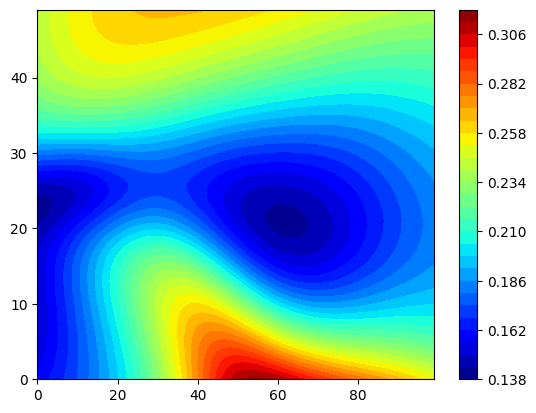

In [22]:
fig, ax = plt.subplots()

plt.contourf(u_plot, levels=30, cmap='jet')
plt.colorbar()

In [23]:
def animate(i):
    ax.clear()
    u_out, v_out, p_out, f_out, g_out = pinn.function(x_test, y_test, i*t_test)
    u_plot = p_out.data.cpu().numpy()
    u_plot = np.reshape(u_plot, (50, 100))
    cax = ax.contourf(u_plot, levels=20, cmap='jet')
    plt.xlabel(r'$x$')
    plt.xlabel(r'$y$')
    plt.title(r'$p(x,\; y, \; t)$')

In [24]:
# Call animate method
ani = animation.FuncAnimation(fig, animate, 20, interval=1, blit=False)
ani.save('p_field_lbfgs.gif')
plt.close()
# Display the plot
plt.show()

MovieWriter ffmpeg unavailable; using Pillow instead.
